In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import pyprogressivex
from utils import download_datasets, load_data, misclassification
from time import time

In [20]:
# Load data from all scenes in the dataset
dataset = "adelaideH"
url_base = 'https://n.ethz.ch/~dbarath/data/'

# Downloading the datasets used for the evaluation if needed
download_datasets(url_base, [dataset])

# Loading the scenes from the downloaded dataset
data = load_data(dataset)


In [21]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, tentatives, img1, img2, mask, color):    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = color, # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return 

def draw_labeling(img1, img2, labeling, correspondences):
    for label in range(max(labeling)):
        mask = labeling == label
        color = random_color(label)

        for i in range(len(labeling)):
            if mask[i]:
                cv2.circle(img1, (round(correspondences[i][0]), round(correspondences[i][1])), 4, color, -1)
                cv2.circle(img2, (round(correspondences[i][2]), round(correspondences[i][3])), 4, color, -1)

    plt.imshow(img1)
    plt.figure()
    plt.imshow(img2)

def random_color(label):
    if label == 0:
        return (255, 0, 0)
    elif label == 1:
        return (0, 255, 0)
    elif label == 2:
        return (0, 0, 255)
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

In [22]:
def process_scene(path, scene, correspondences, ref_labeling, threshold):
    # Load the images
    img1 = cv2.cvtColor(cv2.imread(f"{path}/{scene}/{scene}1.png"), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(f"{path}/{scene}/{scene}2.png"), cv2.COLOR_BGR2RGB)
    
    start = time()
    homographies, labeling = pyprogressivex.findHomographies(np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = threshold,
        conf = 0.5,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = 10,
        maximum_model_number = 6,
        sampler_id = 3,
        do_logging = False) 
    end = time()
    total_time = end - start

    misclassification_error = misclassification(labeling, ref_labeling)   
    print(f"Misclassification error = {misclassification_error:.3f}")
    print(f"Run-time = {total_time:.3f} seconds")
 
    # Draw the results
    draw_labeling(img1, img2, labeling, correspondences)

    return misclassification_error, total_time

Processing scene 'sene'
Misclassification error = 0.012
Run-time = 0.065 seconds
Processing scene 'unionhouse'
Misclassification error = 0.006
Run-time = 0.045 seconds
Processing scene 'unihouse'
Misclassification error = 0.162
Run-time = 0.621 seconds
Processing scene 'hartley'
Misclassification error = 0.013
Run-time = 0.080 seconds
Processing scene 'bonhall'
Misclassification error = 0.108
Run-time = 0.204 seconds
Processing scene 'nese'
Misclassification error = 0.020
Run-time = 0.082 seconds
Processing scene 'physics'
Misclassification error = 0.142
Run-time = 0.046 seconds
Processing scene 'ladysymon'
Misclassification error = 0.030
Run-time = 0.069 seconds
Processing scene 'johnssona'
Misclassification error = 0.056
Run-time = 0.101 seconds
Processing scene 'elderhalla'
Misclassification error = 0.014
Run-time = 0.063 seconds
Processing scene 'bonython'
Misclassification error = 0.015
Run-time = 0.046 seconds
Processing scene 'neem'
Misclassification error = 0.100
Run-time = 0.0

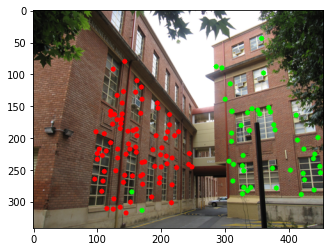

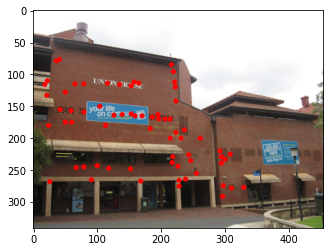

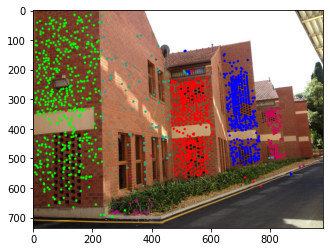

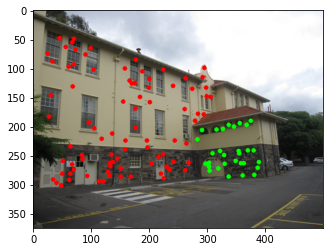

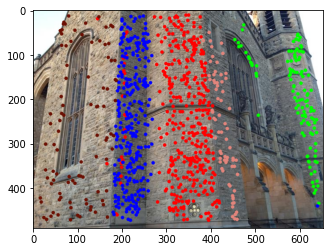

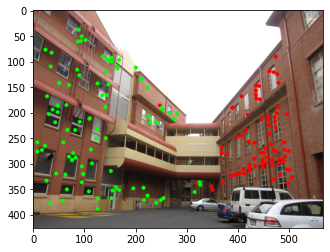

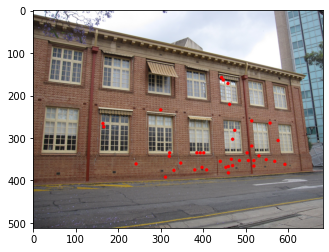

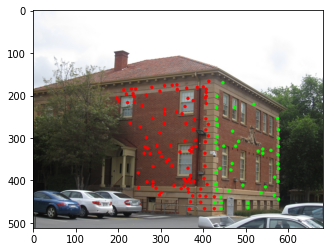

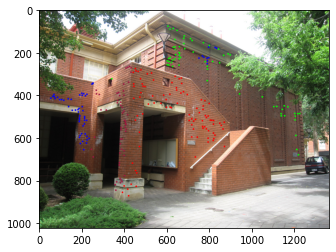

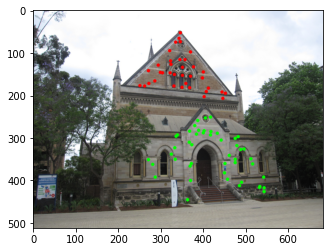

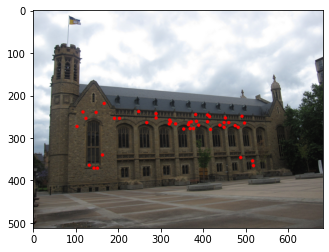

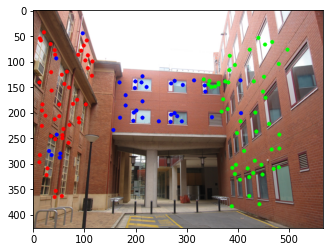

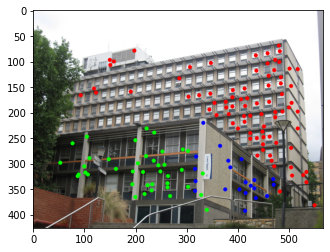

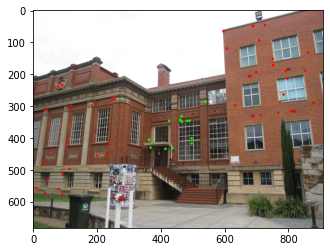

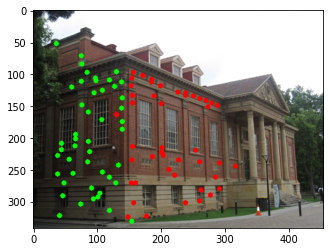

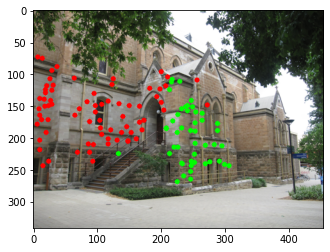

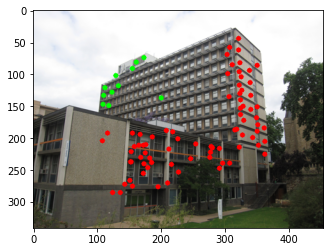

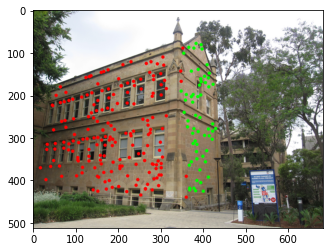

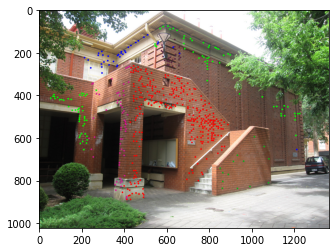

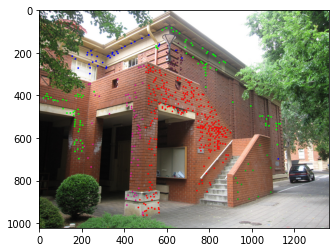

In [23]:
MEs = []
times = []
for scene in data:
    print(f"Processing scene '{scene}'")
    misclassification_error, processing_time = process_scene(f"{dataset}", scene, data[scene]['corrs'], data[scene]['labels'], 4.0)
    MEs.append(misclassification_error)
    times.append(processing_time)

In [24]:
print(f"Average ME on the AdelaideH dataset = {np.mean(MEs):.3f}")
print(f"Average run-time on the AdelaideH dataset = {np.mean(times):.3f} seconds")

Average ME on the AdelaideH dataset = 0.066
Average run-time on the AdelaideH dataset = 0.110 seconds
